In [5]:
import numpy as np
from matplotlib import pyplot as plt

import re

In [2]:
%%time
dati = np.load("Dataset/dati.npy")
dati.shape

CPU times: total: 188 ms
Wall time: 2.02 s


(1000000, 29)

# Verifica di consistenza

Verifico brevemente che i dati usati siano tutti validi, ovvero che non contengano `nan` oppure `inf`

In [3]:
print(f"Numero di nan presenti nei dati: {np.sum(np.isnan(dati))}")
print(f"Numero di inf presenti nei dati: {np.sum(np.isinf(dati))}")
print(f"Tipo dei dati: {dati.dtype}")


Numero di nan presenti nei dati: 0
Numero di inf presenti nei dati: 0
Tipo dei dati: float64


Stando alla [pagina da cui ho prelevato il dataset](https://www.openml.org/search?type=data&status=active&id=42769&sort=runs), alcuni campi hanno 1 attributo mancante, ma io non lo trovo, a me risulta che ci siano tutti!

In [9]:
nSkip = 53
numCol = 29

with open("Dataset/dataset.arff", "r") as f:
    for i, line in enumerate(f.readlines()):
        if i < nSkip: continue
        # if i == nSkip: 
        #     print(line)
        #     print(len(line.split(",")))
        lineSplit = line.split(",")
        if len(lineSplit) != numCol:
            print(f"Numero inconsistente di valori a linea {i}")
            
        if (""," ") in lineSplit:
            print(f"Campo vuoto a linea {i}")
            
            

# Separo i dati
Di seguito creo una matrice `x` ed un vettore `y` che verranno usati per tutte le analisi future:
- X: matrice con le features
- y: vettore con i ground truth

Questi x e y saranno quelli che verranno sempre usati per ciascun classificatore che andrò ad allenare e testare

In [11]:
X = dati[:,1:]
y = dati[:,0]

Definisco un vettore con i nomi in ordine delle varie features.

In [12]:
lstFeatures = (
"lepton_pT",
"lepton_eta",
"lepton_phi",
"missing_energy_magnitude",
"missing_energy_phi",
"jet_1_pt",
"jet_1_eta",
"jet_1_phi",
"jet_1_b-tag",
"jet_2_pt",
"jet_2_eta",
"jet_2_phi",
"jet_2_b-tag",
"jet_3_pt",
"jet_3_eta",
"jet_3_phi",
"jet_3_b-tag",
"jet_4_pt",
"jet_4_eta",
"jet_4_phi",
"jet_4_b-tag",
"m_jj",
"m_jjj",
"m_lv",
"m_jlv",
"m_bb",
"m_wbb",
"m_wwbb",
)

# Distribuzione dei ground truth

## Distribuzione statistica d'insieme
Inizio a studiare le percentuali con cui sono presenti le due classi da classificare all'interno del dataset, e noto che è ben bilanciato, le due classi hanno un numero simile di entries.

In [22]:
# Totale di eventi per le due classi
tot0 = (y==0).sum()
tot1 = (y==1).sum()

# Percentuali
percent0 = tot0 / (tot0 + tot1)
percent1 = tot1 / (tot0 + tot1)


print(f"Numero di classi con target 0: {tot0} -- {percent0:.2f} %")
print(f"Numero di classi con target 1: {tot1} -- {percent1:.2f} %")


# Pie chart
fig, ax = plt.subplots()

ax.pie([tot0, tot1], labels = ("Class 0", "Class 1"), autopct='%1.1f%%',
       colors = ("tab:green", "tab:orange"), textprops = {"color":"k", "backgroundcolor":"lightgrey"})

fig.savefig("../LATEX/FIGURE/01_PieChart.pdf", format = "pdf")

plt.show()

Numero di classi con target 0: 470080 -- 0.47 %
Numero di classi con target 1: 529920 -- 0.53 %


## Distribuzione all'interno del dataset
Vado ora a studiare la distribuzione delle classi da classificare all'interno del dataset



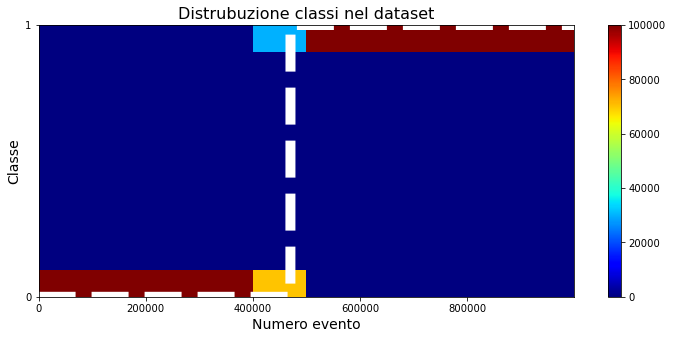

In [41]:
# Indice degli eventi (0, 1, 2....)
timeVect = np.arange(0, X.shape[0], step = 1)

fig, ax = plt.subplots()
fig.set_size_inches(12,5)

h = ax.hist2d(timeVect, y, cmap = "jet")

ax.plot(timeVect, y, c = "w", lw = 10, ls = "--")


ax.set_xlabel("Numero evento", fontsize = 14)
ax.set_ylabel("Classe", fontsize = 14)

ax.set_title("Distrubuzione classi nel dataset", fontsize = 16)

ax.set_yticks((0,1))



fig.colorbar(h[3], ax = ax)

fig.savefig("../LATEX/FIGURE/01_hist2d.pdf", format = "pdf")


plt.show()

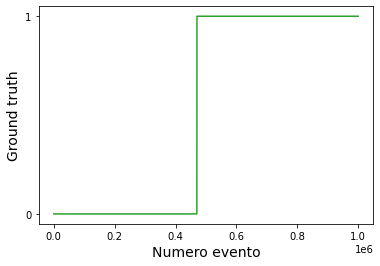

In [11]:
fig, ax = plt.subplots()
ax.plot(timeVect, y, c = "tab:green")

ax.set_xlabel("Numero evento", fontsize = 14)
ax.set_ylabel("Ground truth", fontsize = 14)

ax.set_yticks((0,1))



plt.show()

- Notiamo che la prima metà dei dati è relativa alla classe "0", mentre la seconda metà alla classe "1"
- In questo dataset non esiste (fortunatamente) una feature relativa al numero di evento o al tempo. In caso contrario avrei dovuto dropparla. Sarebbe stata artificiosamente troppo informativa, ma non avrei imparato veramente dai dati...
- Tuttavia il dataset non potrà essere suddiviso in TrS e TeS banalmente prendendo i primi $n$ eventi come TrS ed i restanti ultimi $N-n$ come TeS: un k-fold validation potrebbe sicuramente contribuire a limitare i bias, ma una operazione di reshuffling sarebbe opportuna

# Distribuzioni delle features
Inizio a studiare la distribuzione statistica delle features

//TODO: Distribuzioni statistiche (min, max, mean, std)

In [14]:
%%time

fig, ax = plt.subplots(7, 4)
fig.set_size_inches(30, 100)
ax = ax.flatten()

for i in range(X.shape[1]):
    h, bins = np.histogram(X[:,i], bins = 200)
    binc = bins[:-1] + (bins[1] - bins[0])/2
    ax[i].plot(binc, h, ds = "steps-mid", label = "", c = "tab:green")
    

    
    
    ax[i].grid()
    #ax[i].legend()
    ax[i].set_title(f"Feature: {lstFeatures[i]} ({i})", fontsize = 16)
    
plt.show()
    

CPU times: total: 4.28 s
Wall time: 4.32 s


Noto che alcune features (8, 12, 16, 20) hanno una distribuzione "alquanto singolare". Provo a studiarle più in dettaglio

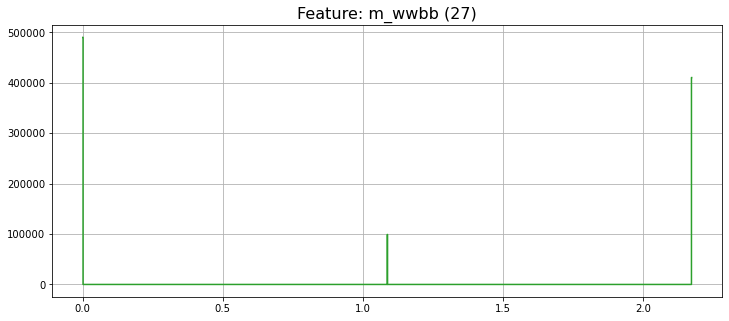

Numero feature: 8
Min: 0.0
Max: 2.1730761528015137
Numero valori == min: 490339
Numero valori == max: 410594
Numero di valori unici presenti: 3


Numero feature: 12
Min: 0.0
Max: 2.2148721218109126
Numero valori == min: 502086
Numero valori == max: 405276
Numero di valori unici presenti: 3


Numero feature: 16
Min: 0.0
Max: 2.548224449157715
Numero valori == min: 569480
Numero valori == max: 354493
Numero di valori unici presenti: 3


Numero feature: 20
Min: 0.0
Max: 3.1019613742828365
Numero valori == min: 648843
Numero valori == max: 292742
Numero di valori unici presenti: 3


CPU times: total: 688 ms
Wall time: 702 ms


In [18]:
%%time

# Per studiare in dettaglio una singola feature
iFeature = 8

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

h, bins = np.histogram(X[:,iFeature], bins = 2000)
binc = bins[:-1] + (bins[1] - bins[0])/2
ax.plot(binc, h, ds = "steps-mid", label = "", c = "tab:green")




ax.grid()
#ax[i].legend()
ax.set_title(f"Feature: {lstFeatures[i]} ({i})", fontsize = 16)
    
plt.show()


for iFeature in (8, 12, 16, 20):
    print(f"Numero feature: {iFeature}")
    print(f"Min: {X[:,iFeature].min()}")
    print(f"Max: {X[:,iFeature].max()}")
    
    print(f"Numero valori == min: {np.sum(X[:,iFeature] == X[:,iFeature].min())}")
    print(f"Numero valori == max: {np.sum(X[:,iFeature] == X[:,iFeature].max())}")
    print(f"Numero di valori unici presenti: {len(np.unique(X[:,iFeature]))}")
    
    print("\n")

Questo conferma l'intuizione precedentemente avuta, ovvero che queste features hanno valori discreti e presentano solo tre possibili valori.

Notiamo inoltre come alcune features (0, 3, 5, 9, 1, 13, 17, 21, 22, 23, 24, 25, 26, 27) abbiano delle distribuzioni "con un picco asimmetrico", altre features (1, 6, 10, 14, 18) hanno invece una forma "gaussiana", con un picco simmetrico. Infine le features (2, 4, 7, 11, 15, 19) risultano essere uniformi in tutti i valori che possono assumere.


## Distribuzioni in funzione del valore target

Studio ora le distribuzioni di ciascuna feature in funzione della classe di appartenenza

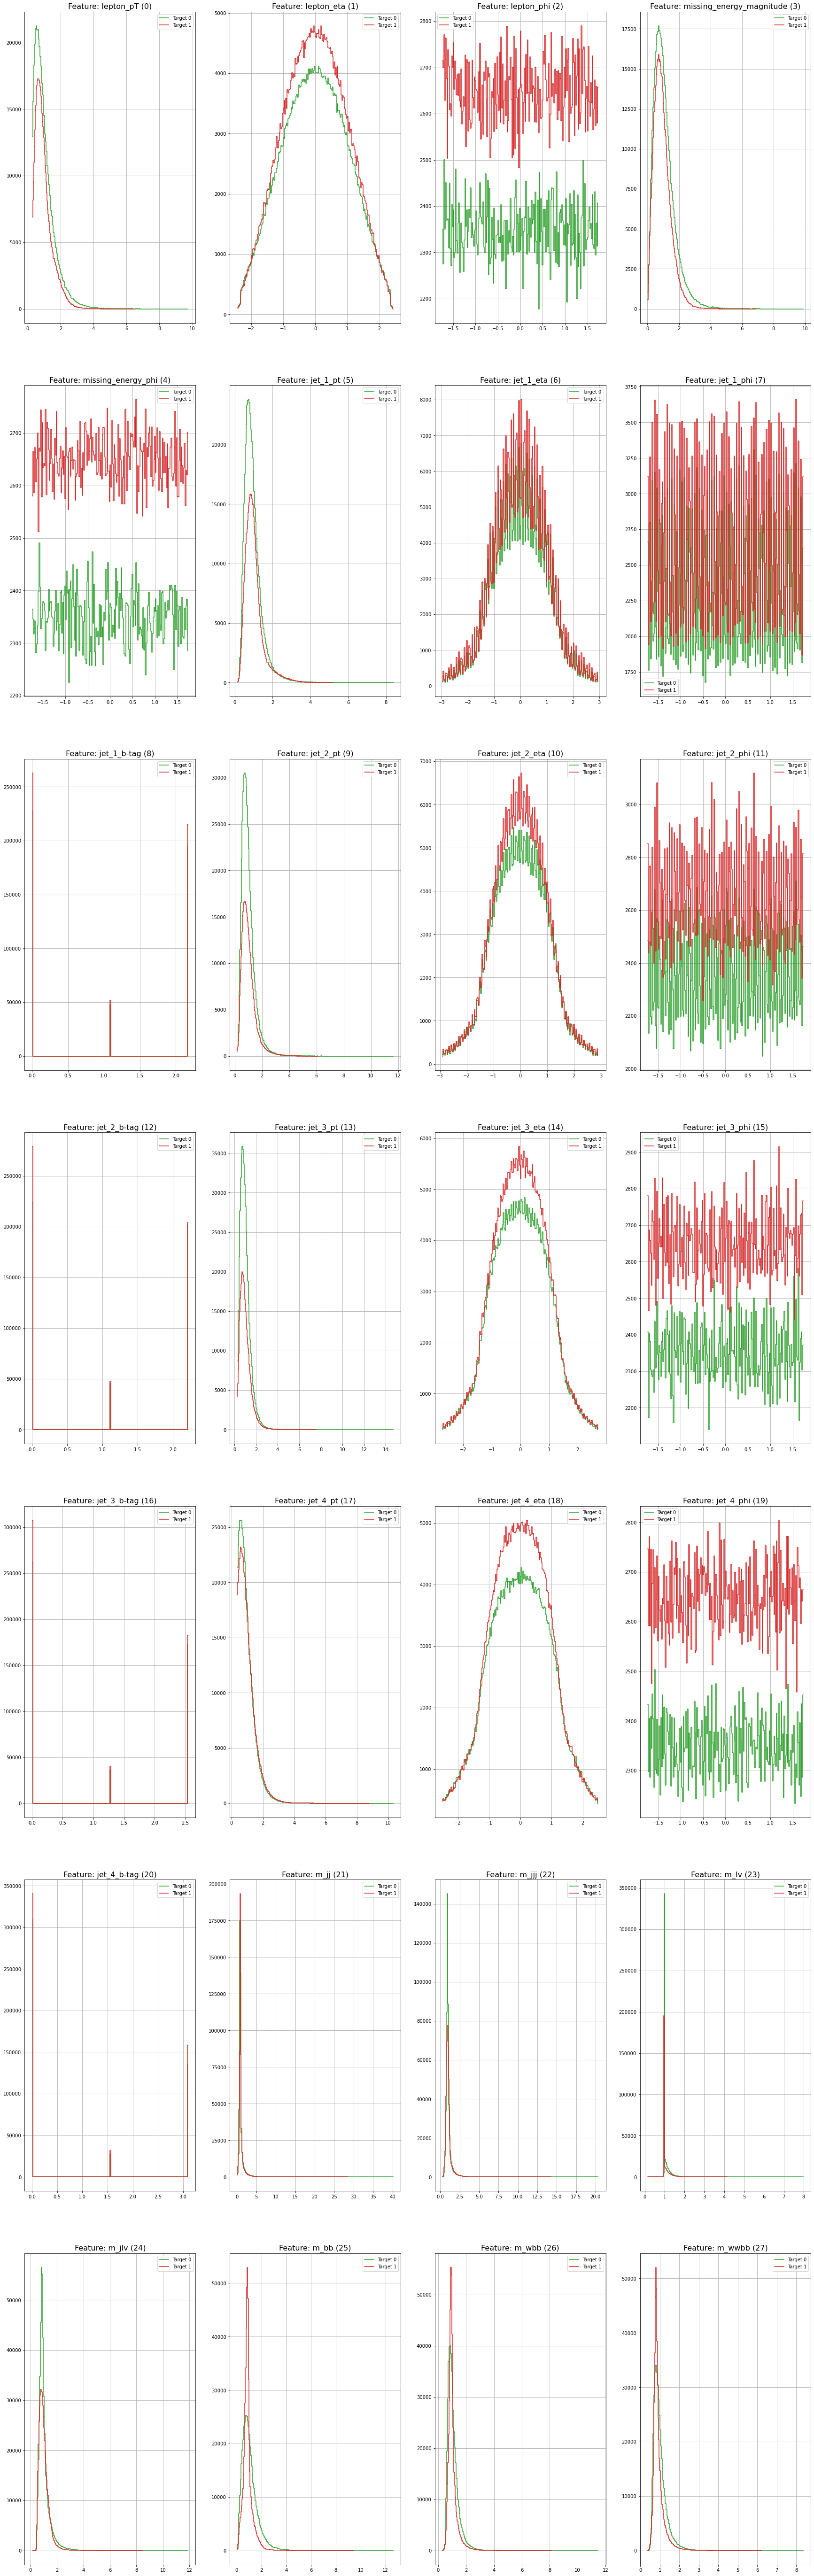

CPU times: total: 5.81 s
Wall time: 5.84 s


In [20]:
%%time

fig, ax = plt.subplots(7, 4)
fig.set_size_inches(30, 100)
ax = ax.flatten()

for i in range(X.shape[1]):
    h, bins = np.histogram(X[:,i][y==0], bins = 200)
    binc = bins[:-1] + (bins[1] - bins[0])/2
    ax[i].plot(binc, h, ds = "steps-mid", label = "Target 0", c = "tab:green")
    
    
    h, bins = np.histogram(X[:,i][y==1], bins = 200)
    binc = bins[:-1] + (bins[1] - bins[0])/2
    ax[i].plot(binc, h, ds = "steps-mid", label = "Target 1", c = "tab:red")
    
    
    ax[i].grid()
    ax[i].legend()
    ax[i].set_title(f"Feature: {lstFeatures[i]} ({i})", fontsize = 16)
    
plt.show()
    

m_jj


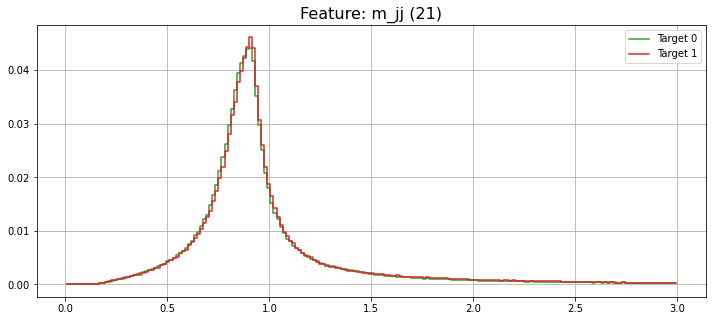

m_jjj


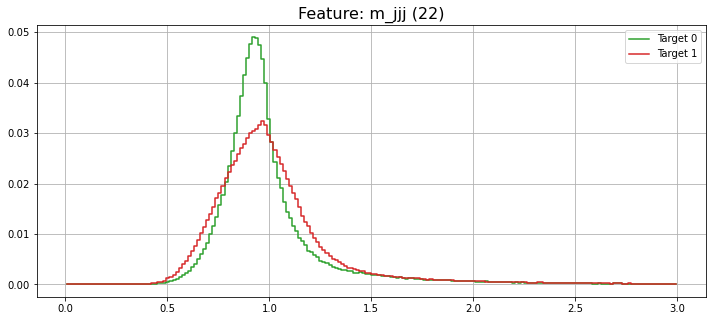

m_lv


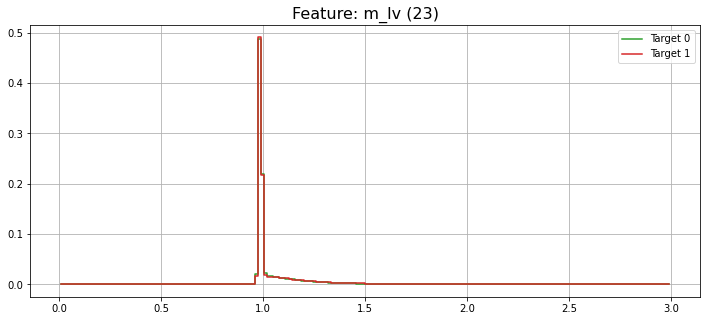

m_jlv


m_bb


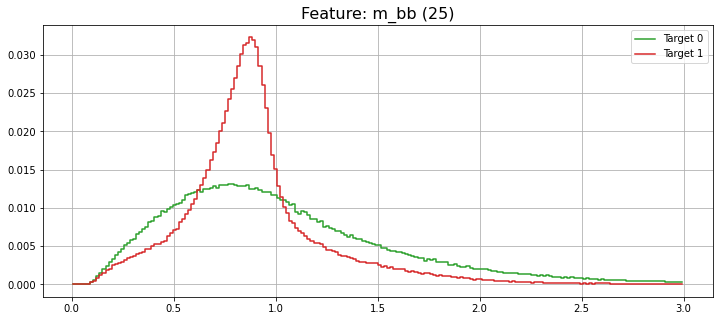

m_wbb


m_wwbb


In [29]:
# Guardo in dettaglio le high-level feature
# Basato sulla costruzione della massa invariante caratteristica (cfr articolo)

opts = { "range":(0, 3), "bins":200}

for i in range(21, 28):
    print(lstFeatures[i])
    
    fig, ax = plt.subplots()
    fig.set_size_inches(12,5)
    
    h, bins = np.histogram(X[:,i][y==0], **opts)
    binc = bins[:-1] + (bins[1] - bins[0])/2
    ax.plot(binc, h/np.sum(h), ds = "steps-mid", label = "Target 0", c = "tab:green")
    
    
    h, bins = np.histogram(X[:,i][y==1], **opts)
    binc = bins[:-1] + (bins[1] - bins[0])/2
    ax.plot(binc, h/np.sum(h), ds = "steps-mid", label = "Target 1", c = "tab:red")
    
    ax.grid()
    ax.legend()
    ax.set_title(f"Feature: {lstFeatures[i]} ({i})", fontsize = 16)

    #ax.set_xlim(0,4)
    
    plt.show()

## Valori feature nel tempo

Studio i valori che ciascuna feature assume in funzione del numero di evento

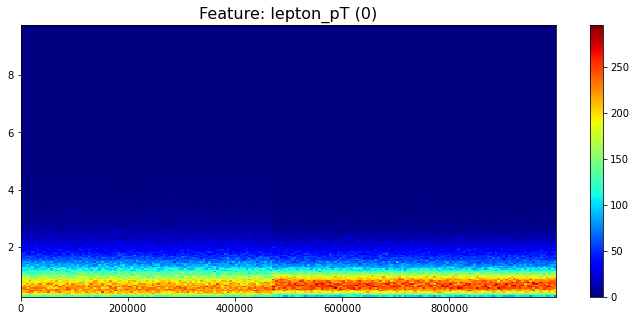

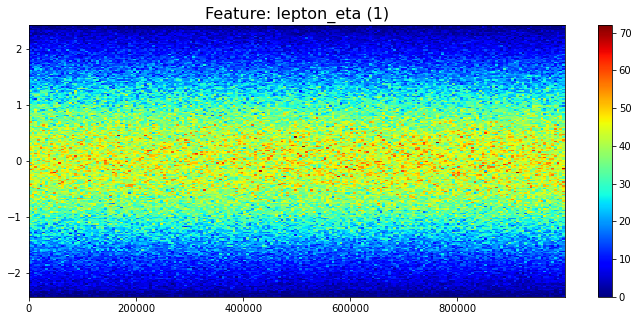

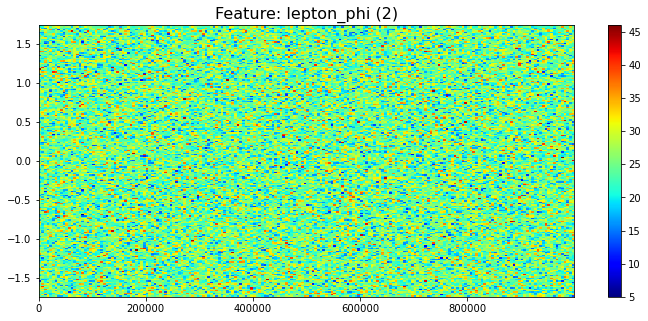

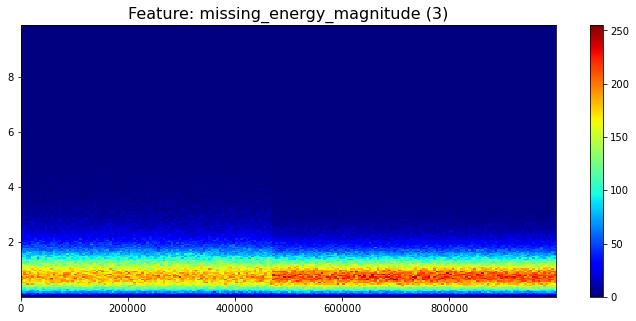

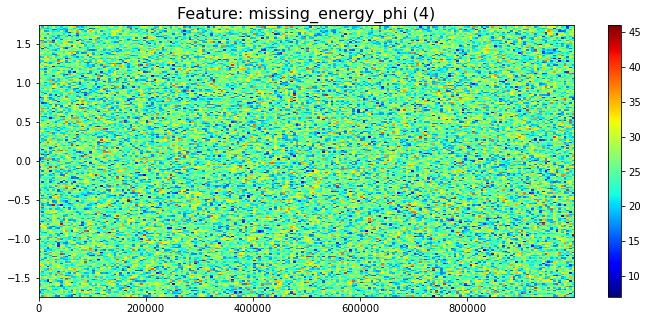

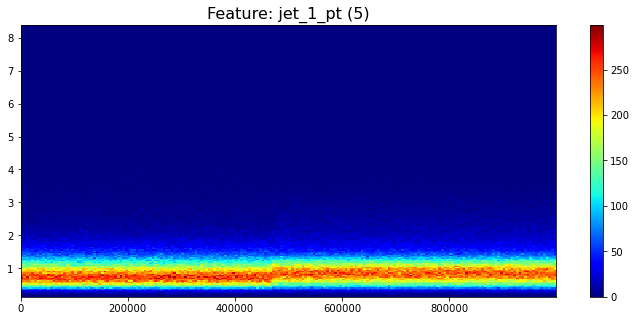

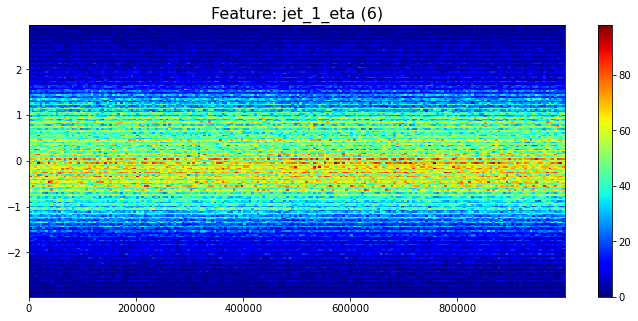

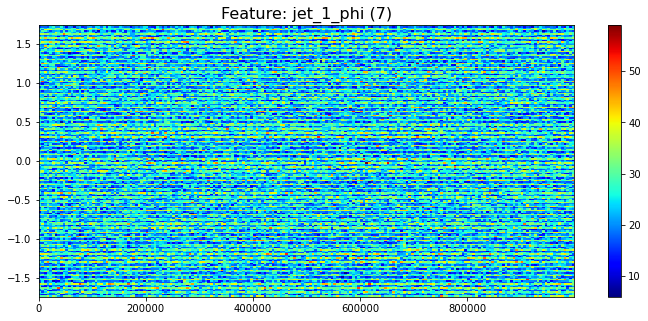

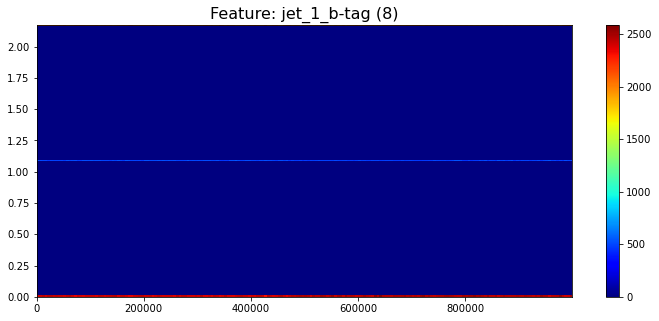

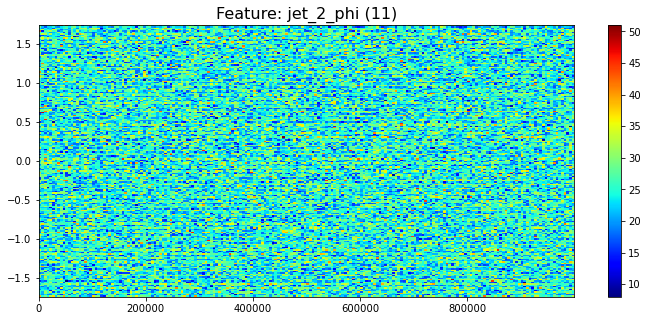

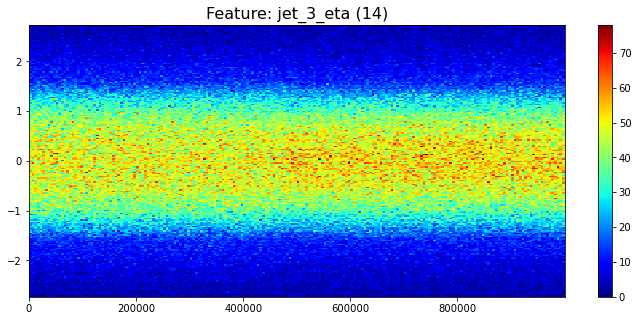

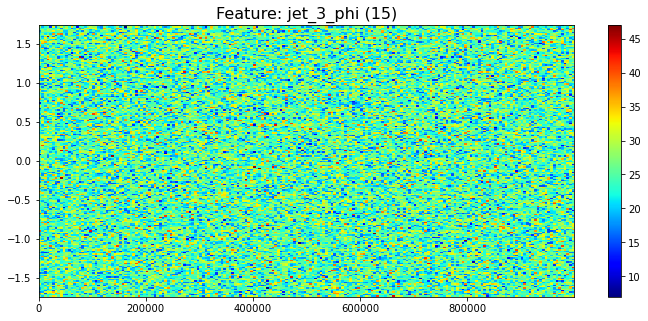

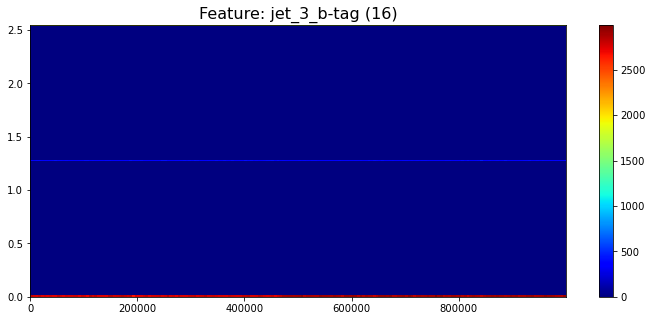

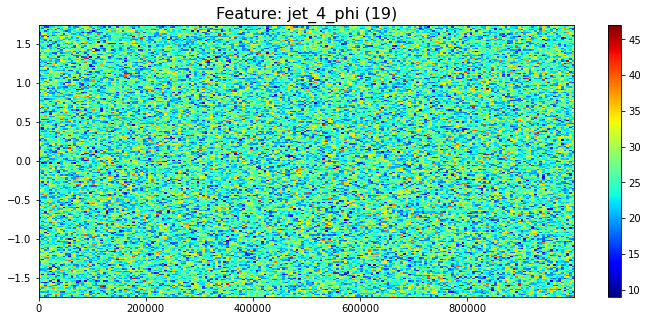

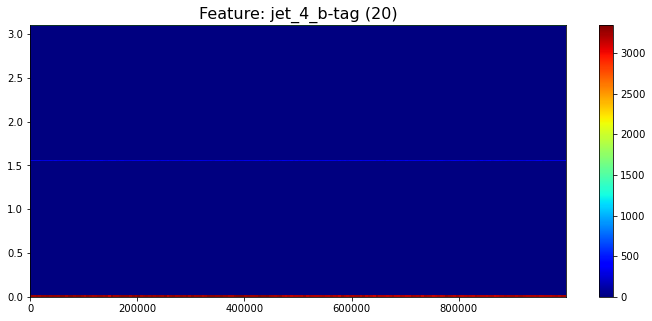

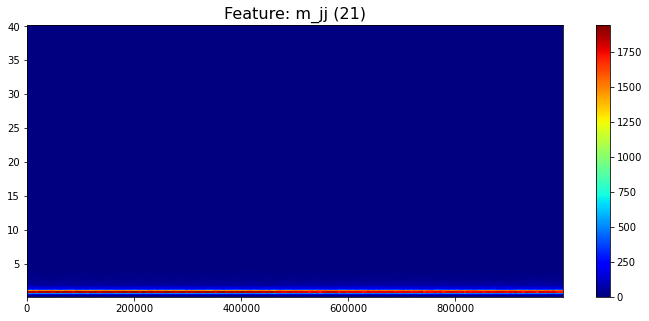

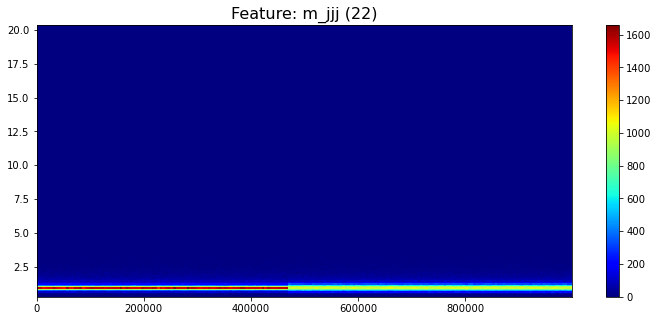

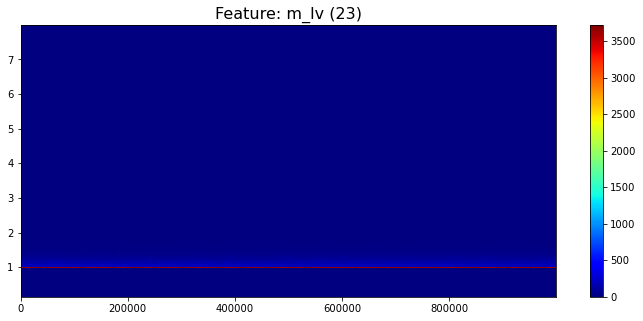

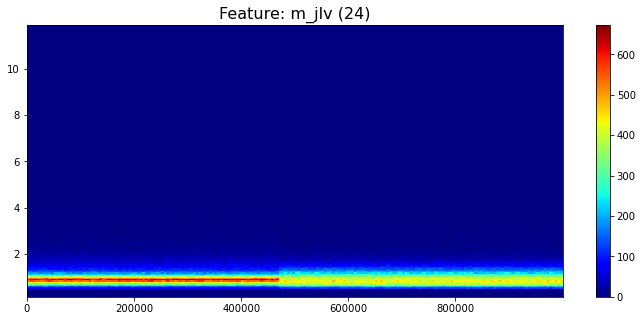

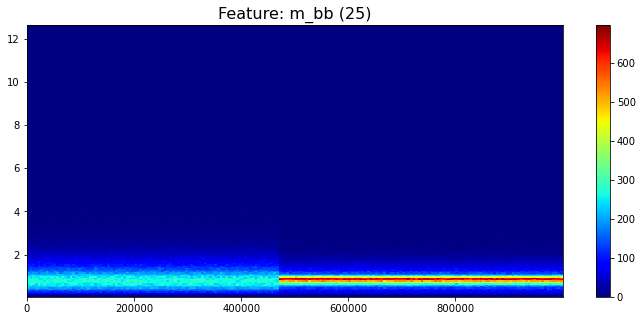

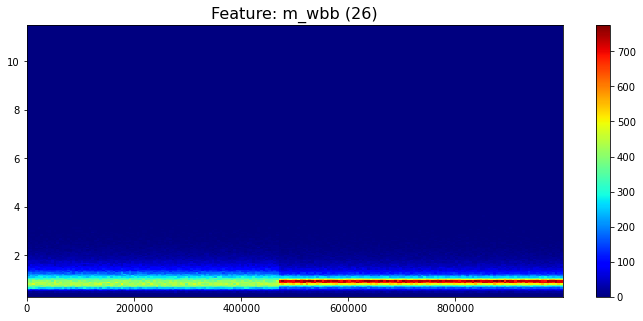

CPU times: total: 8.59 s
Wall time: 8.77 s


In [73]:
%%time

for i in range(x.shape[1]):
    fig, ax = plt.subplots()
    fig.set_size_inches(12,5)
    h = ax.hist2d(timeVect, x[:,i], cmap = "jet", bins = (200, 200), )
    
    ax.set_title(f"Feature: {lstFeatures[i]} ({i})", fontsize = 16)
    
    fig.colorbar(h[3], ax = ax)

    plt.show()
    

Questi grafici non portano un significativo contributo aggiuntivo, se non che a metà si percepisce quasi sempre il cambio di classe di riferimento.

%%time

fig, ax = plt.subplots(28,1)
fig.set_size_inches(30, 300)
ax = ax.flatten()

for i in range(x.shape[1]):
    ax[i].plot(x[:,i], label = "", c = "tab:green")
    
    
    
    ax[i].grid()
    # ax[i].legend()
    ax[i].set_title(f"Feature: {lstFeatures[i]}", fontsize = 16)
    
plt.show()
    